# Model Definition
In this part, we will work on 4 different models : 
- a random forest (Spark ML) that we will use to understand the features importance
- a simple multi-layers neural network (Keras) 
- 2 recurrent neural networks (PyTorch) : one focusing on the sequence inside a segment, the other aiming to catch the link between events from segment to segment

In order to compare the model, we will always use the 3 first quarters of segment for the training and the last quarter as a validation/evaluation set. 

## Model 1 : Random Forest for features selection 

### 1.1 Data preparation

In [1]:
# concatenate the data from the different data sources (x, fft, y)
import os 
from pyspark.sql.types import IntegerType

df_f = spark.read.parquet(os.path.join("kdata", "train.vector.fbin.parquet"))
df_s = spark.read.parquet(os.path.join("kdata", "train.stat.parquet"))
df_y = spark.read.parquet(os.path.join("kdata", "train.target.parquet"))

df_f = df_f.selectExpr("*").drop("_c0")
df_s = df_s.selectExpr("seg AS seg1", "*").drop("seg").drop("_c0")
df_y = df_y.selectExpr("seg AS seg2", "y AS label")

df_train = df_f
df_train = df_train.join(df_s, df_train.seg.cast(IntegerType()) == df_s.seg1.cast(IntegerType())).drop("seg1")
df_train = df_train.join(df_y, df_train.seg.cast(IntegerType()) == df_y.seg2.cast(IntegerType())).drop("seg2")

df_train.printSchema()

root
 |-- f: vector (nullable = true)
 |-- seg: long (nullable = true)
 |-- stat: vector (nullable = true)
 |-- label: double (nullable = true)



In [2]:
# create the feature vector and breakdown the data into training and validation

from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

vect_cols = ["stat","f"]
vectorAssembler = VectorAssembler(inputCols=vect_cols, outputCol="features")

df_train = vectorAssembler.transform(df_train)

trainingData = df_train.selectExpr("*").where("seg < 3145")
testData = df_train.selectExpr("*").where("seg >= 3145")


In [3]:
# evaluator
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mae")


### 1.2 Model definition and fitting

In [4]:
# fit the model, make predictions, save the model
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(
    featuresCol="features",
    labelCol="label",
    predictionCol="prediction",
    numTrees=200,
    maxDepth=30,
    maxBins=32,
    minInstancesPerNode=1,
    minInfoGain=0.0,
    maxMemoryInMB=256,
    cacheNodeIds=False,
    checkpointInterval=10,
    impurity='variance',
    subsamplingRate=1.0,
    seed=None,
    featureSubsetStrategy='auto')

model_rf = rf.fit(trainingData)
predictions_rf = model_rf.transform(testData)

model_rf.write().overwrite().save("model.1.0.spark.rf.data")


### 1.2 Evaluation

In [15]:
# naive method : our prediction is the mean of training
# to give us a flaw of what the mae should be, I've computed the mae for the naive model.  
df_raw = spark.read.parquet(os.path.join("kdata", "train.parquet"))
df_raw.createOrReplaceTempView("data")
raw_training_mean = spark.sql("SELECT AVG(x) AS m FROM data WHERE seg < 3145" ).first().m
mean_pred = testData.selectExpr("*", "CAST({:.16f} AS DOUBLE) AS prediction".format(raw_training_mean))
mae = evaluator.evaluate(mean_pred)
print("mean on training data : {:.16f} ".format(raw_training_mean))
print("mae for wild rule of the thumb (prediction = mean) : {:.8f} ".format(mae))

mean on training data : 4.5547499735029149 
mae for naive method (prediction = mean) : 3.09139370 


In [6]:
import pandas as pd
import numpy as np

mae = evaluator.evaluate(predictions_rf)
print("mae on validation data with random forest model : {:.8f} ".format(mae))

imp = [x for x in model_rf.featureImportances]
cols = ["x_avg", "x_std", "x_skew", "x_kurt", "x_max", "x_p1", "x_p2", "x_p5", "x_p8", "x_p9", 
        "xa_avg", "xa_std", "xa_skew", "xa_kurt", "xa_max", "xa_p1", "xa_p2", "xa_p5", "xa_p8", "xa_p9"]
cols = cols + ["f_"+str(i) for i in range(99)]
feature_imp = pd.DataFrame(imp)
feature_imp = feature_imp.rename(columns={0:"imp"})
feature_imp["name"] = pd.Series(cols)
feature_imp.sort_values(by="imp", ascending=False).head(15).T

mae on validation data with random forest model : 2.39328046 


,19,9,5,77,88,0,78,89,73,72,6,75,76,10,91
imp,0.141868,0.0941222,0.0824252,0.0233884,0.0227513,0.0207749,0.0198919,0.0194569,0.0139165,0.0136857,0.0116475,0.0114148,0.0111934,0.00967242,0.00932256
name,xa_p9,x_p9,x_p1,f_57,f_68,x_avg,f_58,f_69,f_53,f_52,x_p2,f_55,f_56,xa_avg,f_71


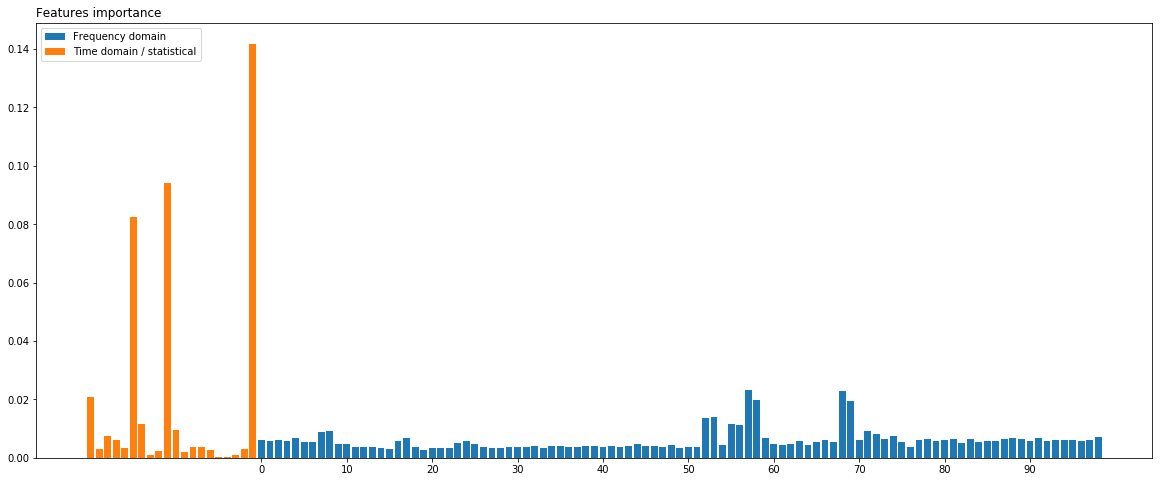

In [7]:
# the features importance plot
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(20,8))
plt.bar(range(-20,len(feature_imp)-20), feature_imp["imp"].values, label="Frequency domain")
plt.bar(range(-20,len(feature_imp.iloc[0:20])-20), feature_imp.iloc[0:20]["imp"].values, label="Time domain / statistical")
# plt.bar(range(len(feature_imp)), feature_imp["imp"].values)
title = ax.set_title("Features importance", loc="left")
legend = plt.legend(loc="upper left")
xticks = plt.xticks(np.arange(0, 100, step=10))

Let's plot the prediction agains the validation data

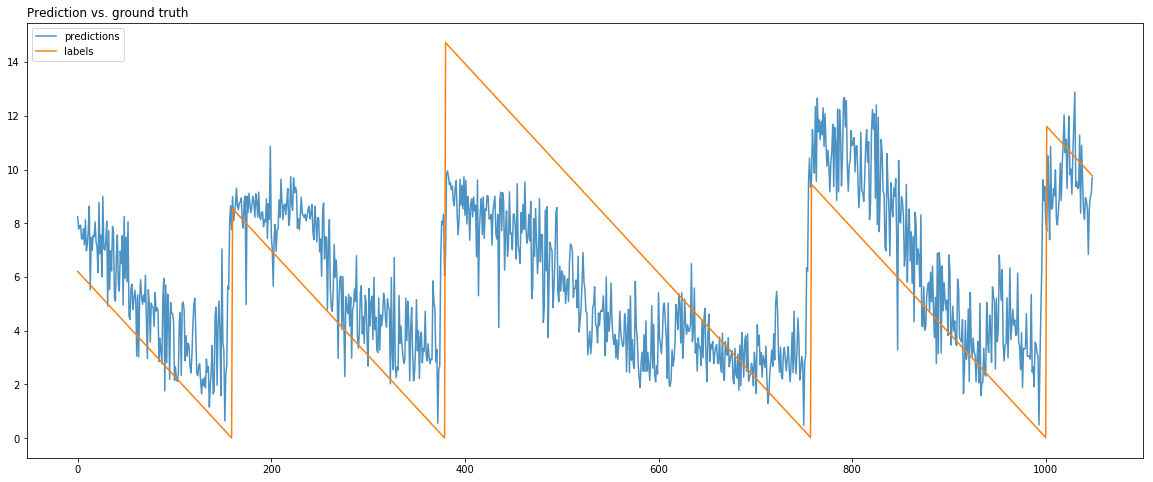

In [8]:
pd_pred = predictions_rf.orderBy("seg").toPandas()
fig, ax = plt.subplots(figsize=(20,8))
plt.plot(pd_pred["prediction"], alpha=0.8, label="predictions")
plt.plot(pd_pred["label"], label="labels")
title = ax.set_title("Prediction vs. ground truth", loc="left")
legend = plt.legend(loc="upper left")

## 1.3 Analysis

This first model gives us a feedback on our feature and can help to go further : 
- extreme percentiles seems to be interesting features for the model, intutively, this makes sense as we have seen that events are peaks in our acoustic data
- some range of frequencies seems more interesting

To go further, there is a few tests we could carry : 
1. test the model with only statistical values 
2. test the model with only frequency values
3. re-engineer our statistical features to focus on the extreme percentile 
4. re-engineer our frequency domain features to focus on the most interesting range
5. test the diffrents association of features

## 1.4 Features selection
In this part, I have grid-tested all combination of data to determine which gives the best result.  

In [16]:
# concatenate the data from the different data sources (x, fft, y)
import os 
from pyspark.sql.types import IntegerType

# df_f = spark.read.parquet(os.path.join("kdata", "train.vector.fbin.parquet"))
df_f = spark.read.parquet(os.path.join("kdata", "train.vector.fbin.2.parquet"))
# df_s = spark.read.parquet(os.path.join("kdata", "train.stat.parquet"))
df_s = spark.read.parquet(os.path.join("kdata", "train.stat.2.parquet"))
df_y = spark.read.parquet(os.path.join("kdata", "train.target.parquet"))

df_f = df_f.selectExpr("*").drop("_c0")
df_s = df_s.selectExpr("seg AS seg1", "*").drop("seg").drop("_c0")
df_y = df_y.selectExpr("seg AS seg2", "y AS label")

df_train = df_f
df_train = df_train.join(df_s, df_train.seg.cast(IntegerType()) == df_s.seg1.cast(IntegerType())).drop("seg1")
df_train = df_train.join(df_y, df_train.seg.cast(IntegerType()) == df_y.seg2.cast(IntegerType())).drop("seg2")

df_train.printSchema()

root
 |-- seg: long (nullable = true)
 |-- f: vector (nullable = true)
 |-- stat: vector (nullable = true)
 |-- label: double (nullable = true)



In [17]:
# create the feature vector

from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

# vect_cols = ["stat","f"]
# vect_cols = ["stat"]
vect_cols = ["f"]
vectorAssembler = VectorAssembler(inputCols=vect_cols, outputCol="features")

df_train = vectorAssembler.transform(df_train)

trainingData = df_train.selectExpr("*").where("seg < 3145")
testData = df_train.selectExpr("*").where("seg >= 3145")


In [18]:
# evaluator
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mae")


In [19]:
# fit the model, make predictions and evaluate against the mae 

from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(
    featuresCol="features",
    labelCol="label",
    predictionCol="prediction",
    numTrees=200,
    maxDepth=30,
    maxBins=32,
    minInstancesPerNode=1,
    minInfoGain=0.0,
    maxMemoryInMB=256,
    cacheNodeIds=False,
    checkpointInterval=10,
    impurity='variance',
    subsamplingRate=1.0,
    seed=None,
    featureSubsetStrategy='auto')

# from pyspark.ml import Pipeline
# pipeline = Pipeline(stages=[vectorAssembler, forest])

model_rf = rf.fit(trainingData)
predictions_rf = model_rf.transform(testData)

model_rf.write().overwrite().save("model.1.1.spark.rf.data")

In [20]:
import pandas as pd
import numpy as np

mae = evaluator.evaluate(predictions_rf)
print("mae on test data with random forest model = {:.8f} ".format(mae))


mae on test data with random forest model = 2.29708506 


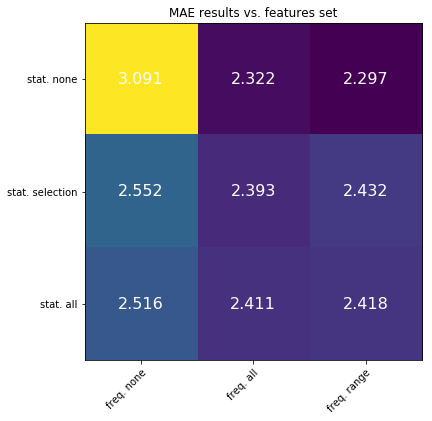

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

stat = ["stat. none", "stat. selection", "stat. all"]
freq = ["freq. none", "freq. all", "freq. range"]

resuts = np.array([ [3.091, 2.322, 2.297],
                    [2.552, 2.393, 2.432],
                    [2.516, 2.411, 2.418]])


fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(resuts)

# We want to show all ticks...
ax.set_xticks(np.arange(len(stat)))
ax.set_yticks(np.arange(len(freq)))
# ... and label them with the respective list entries
ax.set_xticklabels(freq)
ax.set_yticklabels(stat)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(stat)):
    for j in range(len(freq)):
        text = ax.text(j, i, resuts[i, j],
                       ha="center", va="center", color="w", fontsize=16)

ax.set_title("MAE results vs. features set")
fig.tight_layout()
plt.show()

Unsurprisingly, the frequency range gives a better performance. This valids the approach of using the frequency range as our feature set.

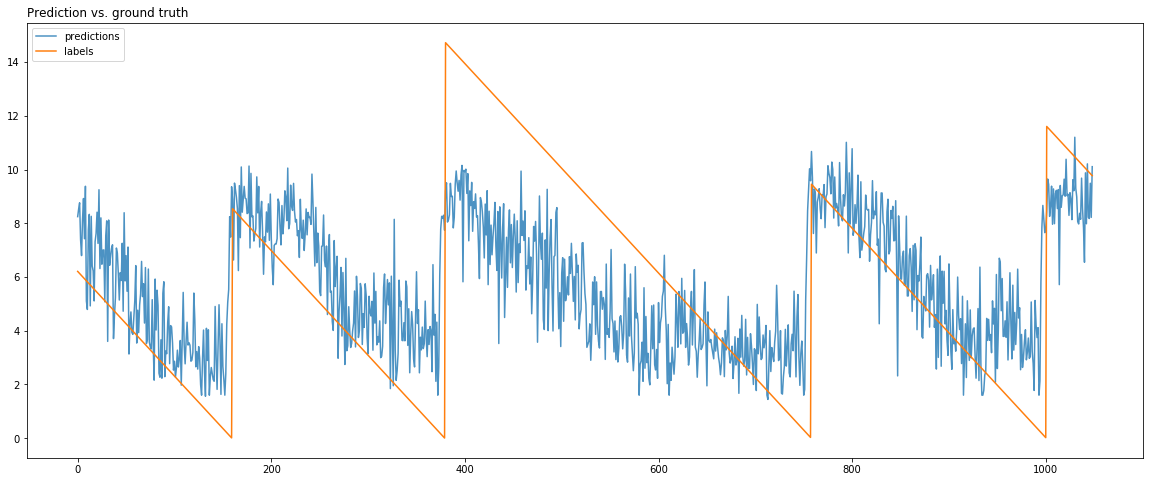

In [23]:
pd_pred = predictions_rf.orderBy("seg").toPandas()
fig, ax = plt.subplots(figsize=(20,8))
plt.plot(pd_pred["prediction"], alpha=0.8, label="predictions")
plt.plot(pd_pred["label"], label="labels")
title = ax.set_title("Prediction vs. ground truth", loc="left")
legend = plt.legend(loc="upper left")

## Model 2 : Simple Neural Network / Keras 

## 2.1 Data preparation
We will use a slice that represent the identified range of the frequency domain. 

In [24]:
import os 
from pyspark.sql.types import IntegerType

df_f = spark.read.parquet(os.path.join("kdata", "train.vector.fbin.2.parquet"))
df_y = spark.read.parquet(os.path.join("kdata", "train.target.parquet"))

df_f = df_f.selectExpr("*").drop("_c0")
df_y = df_y.selectExpr("seg AS seg2", "y AS label")

df_train = df_f
df_train = df_train.join(df_y, df_train.seg.cast(IntegerType()) == df_y.seg2.cast(IntegerType())).drop("seg2")

df_train.printSchema()

root
 |-- seg: long (nullable = true)
 |-- f: vector (nullable = true)
 |-- label: double (nullable = true)



In [25]:
# create the feature vector, training and test sets
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

n_dim = 26 #26 99 119 99+14 20+26 14+26

vect_cols = ["f"]
vectorAssembler = VectorAssembler(inputCols=vect_cols, outputCol="features")

df_train = vectorAssembler.transform(df_train)

trainingData = df_train.selectExpr("*").where("seg < 3145")
testData = df_train.selectExpr("*").where("seg >= 3145")

x_train = trainingData.select("features").orderBy("seg").collect()
x_test = testData.select("features").orderBy("seg").collect()
y_train = trainingData.select("label").orderBy("seg").collect()
y_test = testData.select("label").orderBy("seg").collect()

x_train = np.array(x_train).astype('float32').reshape(-1,n_dim)
x_test = np.array(x_test).astype('float32').reshape(-1,n_dim)
y_train = np.array(y_train).astype('float32').reshape(-1,1)
y_test = np.array(y_test).astype('float32').reshape(-1,1)


### 2.2 Model definition and training

In [27]:
import numpy as np
import keras, math
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.callbacks import Callback
import matplotlib.pyplot as plt

%matplotlib inline

In [28]:
p_dropout = 0.25
activation = 'relu'
model =  Sequential()
model.add(Dense(32, activation=activation, input_shape=(n_dim,)))
model.add(Dropout(p_dropout))
model.add(Dense(32, activation=activation))
model.add(Dropout(p_dropout))
model.add(Dense(64, activation=activation))
model.add(Dropout(p_dropout))
model.add(Dense(1))
model.compile(loss='mae', optimizer=keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                864       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total para

In [29]:
from keras.callbacks import ModelCheckpoint   
checkpointer = ModelCheckpoint(filepath="model.2.0.keras.mlp.hdf5", verbose=1, save_best_only=True)

model.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test), callbacks=[checkpointer], verbose=1)


Train on 3145 samples, validate on 1049 samples
Epoch 1/100
2464/3145 [======================>.......] - ETA: 0s - loss: 4.5465 
Epoch 00001: val_loss improved from inf to 3.62420, saving model to model.2.0.keras.mlp.hdf5
3145/3145 [==============================] - 2s 793us/step - loss: 4.4139 - val_loss: 3.6242
Epoch 2/100
2592/3145 [=======================>......] - ETA: 0s - loss: 3.6685
Epoch 00002: val_loss improved from 3.62420 to 3.40329, saving model to model.2.0.keras.mlp.hdf5
3145/3145 [==============================] - 0s 52us/step - loss: 3.6565 - val_loss: 3.4033
Epoch 3/100
2592/3145 [=======================>......] - ETA: 0s - loss: 3.3816
Epoch 00003: val_loss improved from 3.40329 to 3.10868, saving model to model.2.0.keras.mlp.hdf5
3145/3145 [==============================] - 0s 52us/step - loss: 3.3670 - val_loss: 3.1087
Epoch 4/100
2592/3145 [=======================>......] - ETA: 0s - loss: 3.1037
Epoch 00004: val_loss improved from 3.10868 to 2.80415, saving mode

### 2.3 Results

In [30]:
model.load_weights("model.2.0.keras.mlp.hdf5")

y_hat = model.predict(x_test)

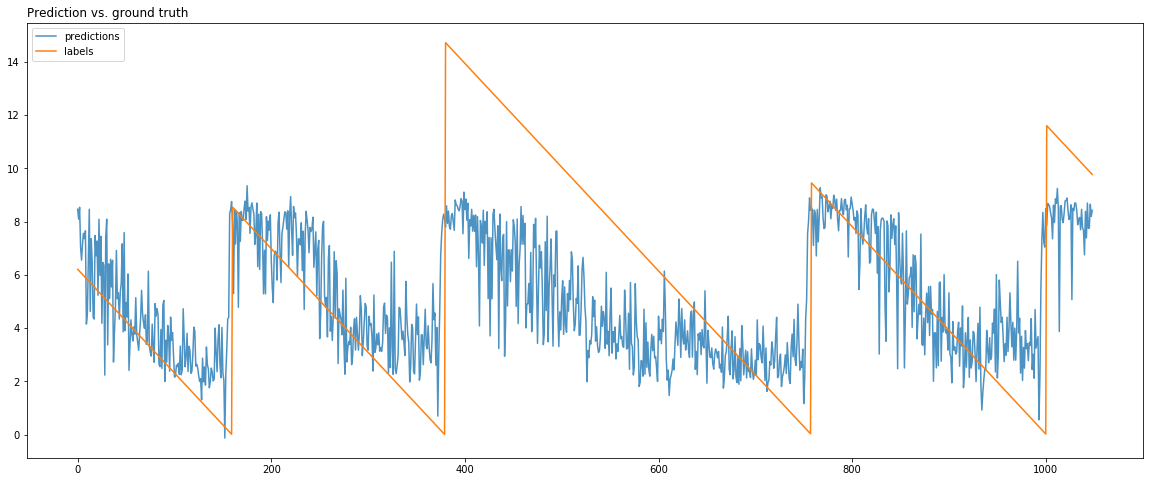

In [31]:
fig, ax = plt.subplots(figsize=(20,8))
plt.plot(y_hat, alpha=0.8, label="predictions")
plt.plot(y_test, label="labels")
title = ax.set_title("Prediction vs. ground truth", loc="left")
legend = plt.legend(loc="upper left")

In [32]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, y_hat)


2.2541761

I don't believe we can go further without adding some data or revising our approach. A track could be to "augment" the data by taking segment that are overlapping with the risk of overfitting. Also, to go further and in the scope of the competition, we could use the validation set to train the model further.  

So far, we have worked on the assumption that, taking the data from the segment we could predict the target, but we have not taken into account the time dependency. Going further, we will then investigate if taking into account a sequence of data, we could give a better prediction. We will work on 2 scopes : inside a segment (segment internal time dependency) and between segments (inter-segments dependencies). 
For the first one, we will need to go back to the ETL step to process the data to have a sequence inside a segment. For the second approach, we can still use the data we already have.  

## Model 3 : Reccurent Neural Network (segment internal time dependencies) / PyTorch 

### 3.1 Data preparation

In [33]:
import os 
from pyspark.sql.types import IntegerType

df_f = spark.read.parquet(os.path.join("kdata", "train.win.vector.fbin.2.parquet"))
df_y = spark.read.parquet(os.path.join("kdata", "train.win.target.parquet"))

df_f = df_f.selectExpr("*").drop("_c0")
df_y = df_y.selectExpr("seg AS seg2", "*").drop("seg")

df_train = df_f
df_train = df_train.join(df_y, df_train.seg.cast(IntegerType()) == df_y.seg2.cast(IntegerType())).drop("seg2")

df_train.printSchema()

root
 |-- seg: long (nullable = true)
 |-- f_sl0: vector (nullable = true)
 |-- f_sl1: vector (nullable = true)
 |-- f_sl2: vector (nullable = true)
 |-- f_sl3: vector (nullable = true)
 |-- f_sl4: vector (nullable = true)
 |-- f_sl5: vector (nullable = true)
 |-- f_sl6: vector (nullable = true)
 |-- f_sl7: vector (nullable = true)
 |-- f: vector (nullable = true)
 |-- y0: double (nullable = true)
 |-- y1: double (nullable = true)
 |-- y2: double (nullable = true)
 |-- y3: double (nullable = true)
 |-- y4: double (nullable = true)
 |-- y5: double (nullable = true)
 |-- y6: double (nullable = true)
 |-- y7: double (nullable = true)



In [35]:
import torch
# test and training set
trainingData = df_train.selectExpr("*").where("seg < 3145")
testData = df_train.selectExpr("*").where("seg >= 3145")

x_train = torch.Tensor([])
x_test = torch.Tensor([])
y_train = torch.Tensor([])
y_test = torch.Tensor([])
for j in range(8):
    x_temp = trainingData.select("f_sl"+str(j)).orderBy("seg").collect()
    x_temp = torch.Tensor(np.array(x_temp).astype('float32')).reshape(-1,1,26)
    if x_train.shape[0] == 0 : x_train = x_temp
    else :
        x_train = torch.cat([x_train, x_temp], 1)

    x_temp = testData.select("f_sl"+str(j)).orderBy("seg").collect()
    x_temp = torch.Tensor(np.array(x_temp).astype('float32')).reshape(-1,1,26)
    if x_test.shape[0] == 0 : x_test = x_temp
    else :
        x_test = torch.cat([x_test, x_temp], 1)

    y_temp = trainingData.select("y"+str(j)).orderBy("seg").collect()
    y_temp = torch.Tensor(np.array(y_temp).astype('float32')).reshape(-1,1)
    if y_train.shape[0] == 0 : y_train = y_temp
    else :
        y_train = torch.cat([y_train, y_temp], 1)
    
    y_temp = testData.select("y"+str(j)).orderBy("seg").collect()
    y_temp = torch.Tensor(np.array(y_temp).astype('float32')).reshape(-1,1)
    if y_test.shape[0] == 0 : y_test = y_temp
    else :
        y_test = torch.cat([y_test, y_temp], 1)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

torch.Size([3145, 8, 26]) torch.Size([1049, 8, 26]) torch.Size([3145, 8]) torch.Size([1049, 8])


In [36]:
# Scale Y 
Y_max = 16.103195566
y_train = y_train/Y_max
y_test = y_test/Y_max

In [37]:
import torch
import torch.nn as nn

class RecN(nn.Module):
    def __init__(self):
        super(RecN, self).__init__()
        self.num_layers = 2
        self.hidden_dim = 12
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.20)
        self.rnn = nn.GRU(26, self.hidden_dim, self.num_layers, batch_first=True, dropout=0.15)
        self.linear1 = nn.Linear(self.hidden_dim, 96)
        self.linear2 = nn.Linear(96, 56)
        self.out = nn.Linear(56, 1)

    def init_hidden(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.hidden_dim)

    def forward(self, x, h, debug=False):
        if debug : print("x-in       \t", x.shape)
        seq_size = x.shape[1]
        x_dim = x.shape[2]
        j, h = self.rnn(x, h)
        if debug : print("hidden out \t", h.shape)
        if debug : print("lstm out   \t", j.shape)
        j = self.dropout(j)
        j = j[:,-1,:]
        if debug : print("format    \t", j.shape)
        j = self.linear1(j)
        if debug : print("l1        \t", j.shape)
        j = self.relu(j)
        j = self.dropout(j)       
        j = self.linear2(j)
        if debug : print("l2        \t", j.shape)
        j = self.relu(j)
        j = self.dropout(j)       
        y = self.out(j)
        if debug : print("l-out     \t", y.shape)
        return y, h

model = RecN()

x = x_train[1].unsqueeze(0)
print(x.shape)
h = model.init_hidden(x.shape[0]) 
print(h.shape)
y_hat,_ = model(x, h, debug=True)
print(y_hat.shape)
print(y_hat)

torch.Size([1, 8, 26])
torch.Size([2, 1, 12])
x-in       	 torch.Size([1, 8, 26])
hidden out 	 torch.Size([2, 1, 12])
lstm out   	 torch.Size([1, 8, 12])
format    	 torch.Size([1, 12])
l1        	 torch.Size([1, 96])
l2        	 torch.Size([1, 56])
l-out     	 torch.Size([1, 1])
torch.Size([1, 1])
tensor([[-0.0567]], grad_fn=<AddmmBackward>)


### 3.2 Model preparation and training

In [40]:
model = RecN()
loss_f = torch.nn.L1Loss(reduction="mean")
optimiser = torch.optim.Adam(model.parameters(), lr=0.001, 
                              betas=(0.92, 0.999), eps=1e-10, amsgrad=True,                               
                              weight_decay= 0.0000)

num_epochs = 600
loss_train = 0
valid_loss = 100000
best_model = RecN()
hist_t, hist_v = [], []
for t in range(num_epochs):
    
    model.train()
    hidden = model.init_hidden(x_train.shape[0])
    for i in range(x_train.shape[1]):
        optimiser.zero_grad()
        y_hat, hidden = model(x_train[:,i].view(-1,1,26), hidden)
        loss = loss_f(y_hat, y_train[:,i].view(-1,1))
        loss.backward()
        optimiser.step()
        hidden = hidden.detach()
    if t%50==0 : loss_train = (loss.item()*Y_max)
    hist_t.append(loss.item()*Y_max)

    model.eval()
    hidden = model.init_hidden(x_test.shape[0])
    for i in range(x_test.shape[1]):
        with torch.no_grad():
            y_hat, hidden = model(x_test[:,i].view(-1,1,26), hidden)
    loss = loss_f(y_hat, y_test[:,i].view(-1,1))
    if loss.item() < valid_loss: 
        valid_loss = loss.item()  
        best_model.load_state_dict(model.state_dict())

    if t%50==0 : print("#{:04} \tTrn.: {:.06f}\t Vld.: {:.06f}\t Bst.: {:.06f}".format(t, loss_train, loss.item()*Y_max, valid_loss*Y_max))
    hist_v.append(loss.item()*Y_max)


torch.save(best_model.state_dict(), "model.3.0.pytorch.rnn.pt")
print("done!")

#0000 	Trn.: 3.142458	 Vld.: 3.049492	 Bst.: 3.049492
#0050 	Trn.: 2.293491	 Vld.: 2.292355	 Bst.: 2.262644
#0100 	Trn.: 2.246858	 Vld.: 2.235029	 Bst.: 2.234555
#0150 	Trn.: 2.227839	 Vld.: 2.333373	 Bst.: 2.226969
#0200 	Trn.: 2.198133	 Vld.: 2.361651	 Bst.: 2.222257
#0250 	Trn.: 2.211098	 Vld.: 2.232623	 Bst.: 2.216774
#0300 	Trn.: 2.183440	 Vld.: 2.213083	 Bst.: 2.212388
#0350 	Trn.: 2.184956	 Vld.: 2.246243	 Bst.: 2.212388
#0400 	Trn.: 2.195507	 Vld.: 2.221465	 Bst.: 2.212388
#0450 	Trn.: 2.188392	 Vld.: 2.217531	 Bst.: 2.212388
#0500 	Trn.: 2.177722	 Vld.: 2.256427	 Bst.: 2.212388
#0550 	Trn.: 2.201001	 Vld.: 2.255189	 Bst.: 2.212388
done!


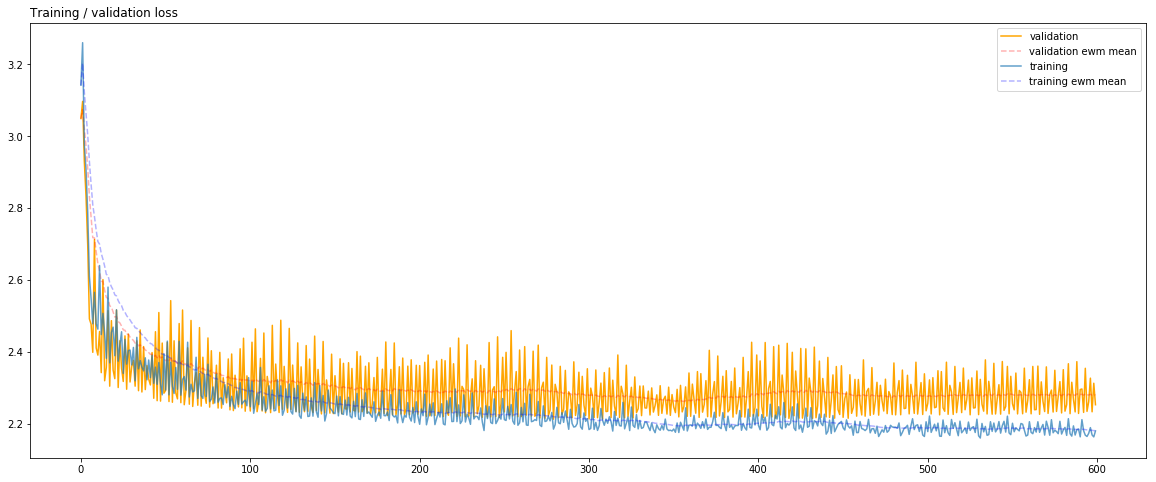

In [45]:
fig, ax = plt.subplots(figsize=(20,8))
title = ax.set_title("Training / validation loss", loc="left")
training_hist = pd.DataFrame([h for h in hist_t])
validation_hist = pd.DataFrame([h for h in hist_v])
plt.plot([h for h in hist_v], color='orange', label="validation")
plt.plot(validation_hist[0].ewm(alpha=0.05).mean(), label="validation ewm mean", alpha=0.3, ls="--", color="red")
plt.plot([h for h in hist_t], alpha=0.7, label="training")
plt.plot(training_hist[0].ewm(alpha=0.05).mean(), label="training ewm mean", alpha=0.3, ls="--", color="blue")
plt.legend()

### 3.3 Results

2.2123878

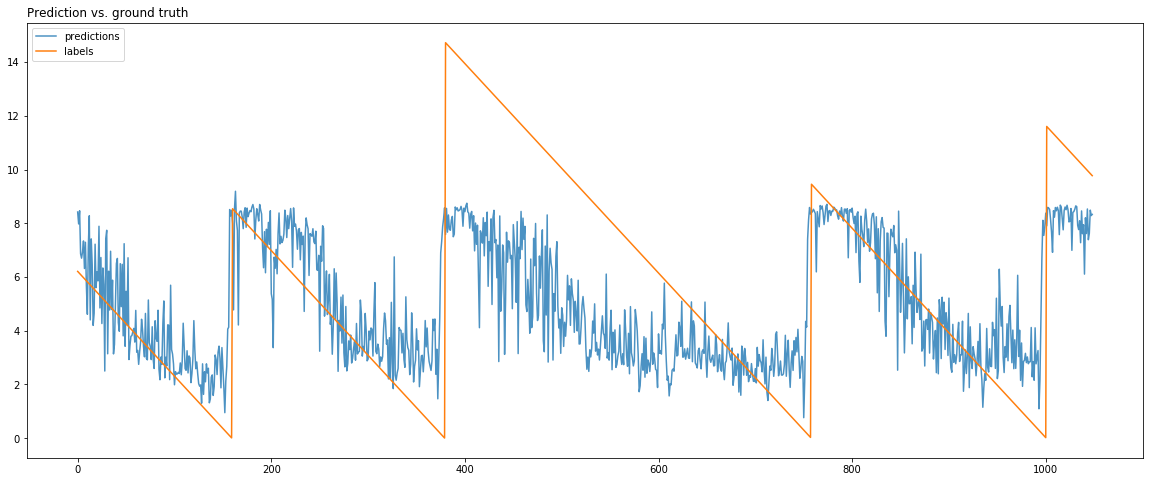

In [46]:
best_model.eval()
hidden = best_model.init_hidden(x_test.shape[0])
for i in range(x_test.shape[1]):
    with torch.no_grad():
        y_hat, hidden = best_model(x_test[:,i].view(-1,1,26), hidden)

fig, ax = plt.subplots(figsize=(20,8))
plt.plot(y_hat.squeeze(0).numpy()*Y_max, alpha=0.8, label="predictions")
plt.plot(y_test[:,i].view(-1,1).squeeze(0).numpy()*Y_max, label="labels")
title = ax.set_title("Prediction vs. ground truth", loc="left")
legend = plt.legend(loc="upper left")

from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test[:,i].view(-1,1).squeeze(0).numpy()*Y_max, y_hat.squeeze(0).numpy()*Y_max)


## Model 4 : Reccurent Neural Network (inter-segments dependencies) / PyTorch

### 4.1 Data preparation

In [47]:
import os 
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import VectorSlicer


df_f = spark.read.parquet(os.path.join("kdata", "train.vector.fbin.2.parquet"))
slicer = VectorSlicer(inputCol="f", outputCol="fsl", indices=[i for i in range(0,26,2)])
df_f = slicer.transform(df_f).drop("f")
df_y = spark.read.parquet(os.path.join("kdata", "train.target.parquet"))

df_f = df_f.selectExpr("*").drop("_c0")
df_y = df_y.selectExpr("seg AS seg2", "y as label").drop("seg")

df_train = df_f
df_train = df_train.join(df_y, df_train.seg.cast(IntegerType()) == df_y.seg2.cast(IntegerType())).drop("seg2")

df_train.printSchema()

root
 |-- seg: long (nullable = true)
 |-- fsl: vector (nullable = true)
 |-- label: double (nullable = true)



In [48]:
# test and training set

import torch
import numpy as np

Data = df_train.selectExpr("*").orderBy("seg")

x_train = torch.Tensor([])
x_train = Data.select("fsl").orderBy("seg").collect()
x_train = torch.Tensor(np.array(x_train).astype('float32')).reshape(-1,1,13)
        
y_train = Data.select("label").orderBy("seg").collect()
y_train = torch.Tensor(np.array(y_train).astype('float32'))

print(x_train.shape, y_train.shape)

torch.Size([4194, 1, 13]) torch.Size([4194, 1])


In [49]:
# Scale Y 
Y_max = 16.103195566
y_train = y_train/Y_max

In [50]:
import torch
import torch.nn as nn

class LongRecN(nn.Module):
    def __init__(self):
        super(LongRecN, self).__init__()
        self.sequence = 8 
        self.hidden_dim = 13
        self.num_layers = 2

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.25)

        self.rnn = nn.GRU(13, self.hidden_dim, self.num_layers, batch_first=True, dropout=0.15)

        self.linear1 = nn.Linear(self.hidden_dim, 128)
        self.linear2 = nn.Linear(128, 64)
        self.out = nn.Linear(64, 1)

    def init_hidden(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.hidden_dim)

    def forward(self, x, h, debug=False):
        if debug : print("x-in       \t", x.shape)
        seq_size = x.shape[1]
        x_dim = x.shape[2]
        j, h = self.rnn(x, h)
        if debug : print("hidden out \t", h.shape)
        if debug : print("lstm out   \t", j.shape)
        j = self.dropout(j)
        j = j[:,-1,:] # keep last of the stack
        if debug : print("format    \t", j.shape)
        j = self.linear1(j)
        if debug : print("l1        \t", j.shape)
        j = self.relu(j)
        j = self.dropout(j)       
        j = self.linear2(j)
        if debug : print("l2        \t", j.shape)
        j = self.relu(j)
        j = self.dropout(j)       
        y = self.out(j)
        if debug : print("l-out     \t", y.shape)
        return y, h

model = LongRecN()

x = x_train[1].unsqueeze(0)
print(x.shape)
h = model.init_hidden(x.shape[0]) 
print(h.shape)
y_hat,_ = model(x, h, debug=True)
print(y_hat.shape)
print(y_hat)

torch.Size([1, 1, 13])
torch.Size([2, 1, 13])
x-in       	 torch.Size([1, 1, 13])
hidden out 	 torch.Size([2, 1, 13])
lstm out   	 torch.Size([1, 1, 13])
format    	 torch.Size([1, 13])
l1        	 torch.Size([1, 128])
l2        	 torch.Size([1, 64])
l-out     	 torch.Size([1, 1])
torch.Size([1, 1])
tensor([[-0.1067]], grad_fn=<AddmmBackward>)


### 4.2 Model definition and training

In [52]:
import random

model = LongRecN()
loss_f = torch.nn.L1Loss(reduction="mean")
optimiser = torch.optim.Adam(model.parameters(), lr=0.001, 
                              betas=(0.90, 0.999), eps=1e-10, amsgrad=True,                               
                              weight_decay= 0.0000)

num_epochs = 150
nb_timestep = 131*4 
loss_train = 0
valid_loss = 100000
best_model = LongRecN()
hist_t, hist_v, hist_vv = [], [], []
loss_t, loss_v = .0, .0
#training over each part
max_id = 0
for part_id in range(2,3):
    id_max = (part_id+1)*1048

    for t in range(num_epochs):
        
        # training : from zero to id max, forward/backard each segment 1 by 1 sequentially
        model.train()
        batch_size = 24
        hidden = model.init_hidden(batch_size)
        # we select a segment to start with and we will then process the following 1048 segments
        idx = [random.randint(0,1048*2) for _ in range(batch_size)]
        X, Y = None, None
        for i in range(1048):
            for b in range(batch_size):
                max_id = max(max_id,idx[b]+i)
                X1, Y1 = x_train[idx[b]+i].view(1,x_train.shape[1],x_train.shape[2]), y_train[idx[b]+i].view(1,-1)
                if b==0 : X, Y = X1, Y1
                else: X, Y = torch.cat([X,X1], 0), torch.cat([Y,Y1], 0) 
            # trick: we cumulate the gradient over several forward pass  
            if i % nb_timestep == 0 : 
                optimiser.zero_grad()
            y_hat, hidden = model(X, hidden)
            # trick: when we have done our (nb_timestep) forward pass, we perform the backward and step 
            if i % nb_timestep == nb_timestep-1 : 
                loss = loss_f(y_hat, Y)
                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(), 5)
                optimiser.step()
                hidden = hidden.detach()
            loss2 = loss_f(y_hat, Y)
            loss_t = ( loss_t * i + loss2.item()*Y_max ) /(i+1)
        hist_t.append(loss_t)
        
        model.eval()
        hidden = model.init_hidden(1)
        for i in range(1048):
            X, Y = x_train[id_max+i].view(1,x_train.shape[1],x_train.shape[2]), y_train[id_max+i]
            with torch.no_grad():
                y_hat, hidden = model(X, hidden)
            loss = loss_f(y_hat, Y)
            loss_v = ( loss_v * i + loss.item()*Y_max ) /(i+1)
        if loss_v < valid_loss: 
            valid_loss = loss_v  
            best_model.load_state_dict(model.state_dict())
        hist_v.append(loss_v)
        hist_vv.append(valid_loss)

        print("{}.#{:04} \tTrn.: {:.06f}\t Vld.: {:.06f}\t Bst.: {:.06f} \t{}|{}".format(part_id, t, loss_t, loss_v, 
                                                                                         valid_loss, max_id, id_max), end="\r")
        if t%10==0 : print("")

print("")
torch.save(best_model.state_dict(), "model.4.0.pytorch.lrnn.pt")
print("done!")

2.#0000 	Trn.: 6.155979	 Vld.: 4.998508	 Bst.: 4.998508 	3049|3144
2.#0010 	Trn.: 3.094389	 Vld.: 3.022244	 Bst.: 3.022244 	3141|3144
2.#0020 	Trn.: 3.027924	 Vld.: 2.832706	 Bst.: 2.832706 	3143|3144
2.#0030 	Trn.: 2.709692	 Vld.: 2.534749	 Bst.: 2.534749 	3143|3144
2.#0040 	Trn.: 2.542981	 Vld.: 2.304918	 Bst.: 2.211337 	3143|3144
2.#0050 	Trn.: 2.482458	 Vld.: 2.102389	 Bst.: 2.001648 	3143|3144
2.#0060 	Trn.: 2.367386	 Vld.: 2.063153	 Bst.: 1.999120 	3143|3144
2.#0070 	Trn.: 2.454433	 Vld.: 2.192546	 Bst.: 1.998699 	3143|3144
2.#0080 	Trn.: 2.392135	 Vld.: 2.000849	 Bst.: 1.995945 	3143|3144
2.#0090 	Trn.: 2.373022	 Vld.: 2.071054	 Bst.: 1.992918 	3143|3144
2.#0100 	Trn.: 2.248760	 Vld.: 2.030679	 Bst.: 1.992918 	3143|3144
2.#0110 	Trn.: 2.200891	 Vld.: 1.993525	 Bst.: 1.992918 	3143|3144
2.#0120 	Trn.: 2.274092	 Vld.: 2.010826	 Bst.: 1.992918 	3143|3144
2.#0130 	Trn.: 2.186269	 Vld.: 2.029799	 Bst.: 1.992918 	3143|3144
2.#0140 	Trn.: 2.154842	 Vld.: 2.043872	 Bst.: 1.992918 	3143|

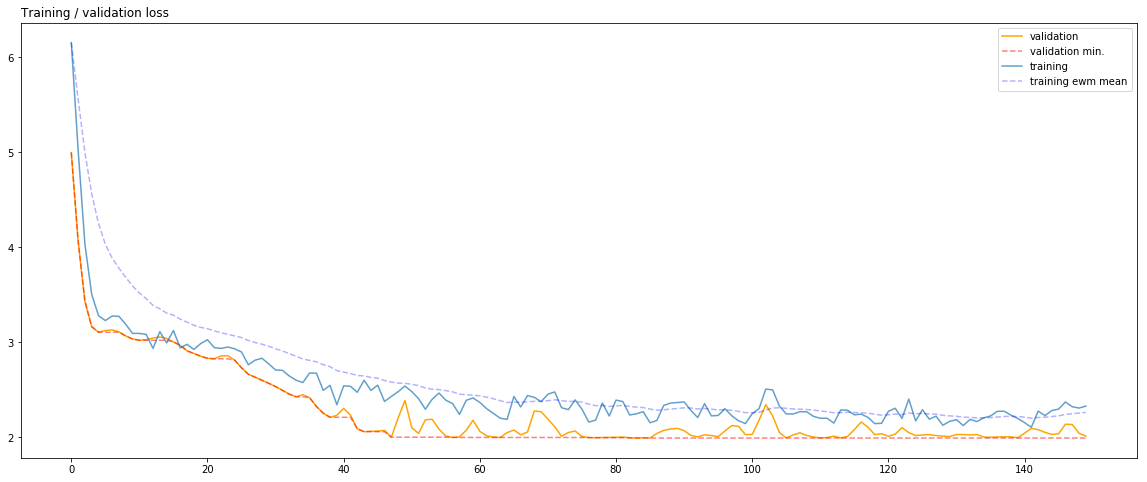

In [53]:
fig, ax = plt.subplots(figsize=(20,8))
title = ax.set_title("Training / validation loss", loc="left")
training_hist = pd.DataFrame([h for h in hist_t])
plt.plot([h for h in hist_v], color='orange', label="validation")
plt.plot([h for h in hist_vv], color='red', label="validation min.", alpha=0.5, ls="--")
plt.plot([h for h in hist_t], alpha=0.7, label="training")
plt.plot(training_hist[0].ewm(alpha=0.1).mean(), label="training ewm mean", alpha=0.3, ls="--", color="blue")
plt.legend()
# ax.set_ylim(2.1,2.6)


### 4.3 Results

1.9929183

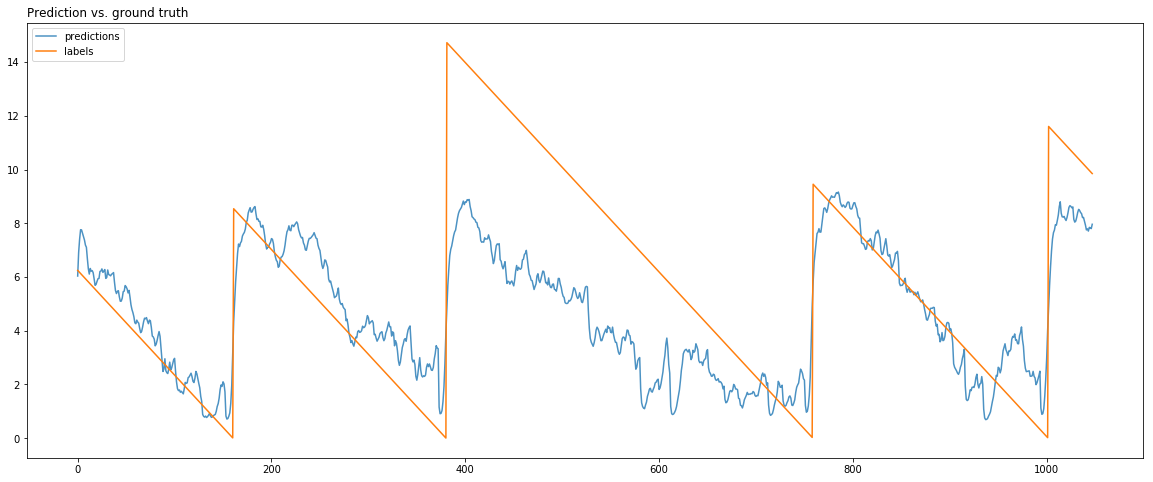

In [54]:
best_model.eval()
hidden = best_model.init_hidden(1)
id_max = 1048 * 3
y_hat = []
for i in range(1048):
    X, Y = x_train[id_max+i].view(1,x_train.shape[1],x_train.shape[2]), y_train[id_max+i]
    with torch.no_grad():
        y_hat_1, hidden = best_model(X, hidden)
    y_hat.append(y_hat_1*Y_max)

fig, ax = plt.subplots(figsize=(20,8))
plt.plot(y_hat, alpha=0.8, label="predictions")
plt.plot(y_train[id_max:id_max+1048].numpy()*Y_max, label="labels")
title = ax.set_title("Prediction vs. ground truth", loc="left")
legend = plt.legend(loc="upper left")

from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_train[id_max:id_max+1048].numpy()*Y_max, y_hat)
